# Cifar10 dataset

# Import the packages

In [1]:
import torch
import torch.nn as nn
import torchvision

# Setup
# Preprocessing

In [2]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# TODO: investigate the rescalling option
# IMG_SIZE = 160 # origninal img size (32, 32, 3), optimal img size (224, 224, 3)

# Define a transform to normalize the data
transform: Compose = Compose([
    
    Resize((160, 160)),
    
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    ToTensor(), 
    
    # Normalize a tensor image with mean and standard deviation.
    # output[channel] = (input[channel] - mean[channel]) / std[channel] -> normalised = (original - 0.5) / 0.5]
    # Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

## Load the dataset

In [3]:
from torch import Tensor
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

# load the full CIFAR-10 training data
full_trainset: CIFAR10 = CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

# split the full training data into train and validation sets
train_size: int = int(0.8 * len(full_trainset))
valid_size: int = len(full_trainset) - train_size

# TODO: check annotation type, and understand the function
trainset, validset = random_split(full_trainset, [train_size, valid_size])

# load the test data
testset: CIFAR10 = CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# print dataset sizes
print(f"All samples: {len(trainset)+len(validset)+len(testset)}")
print(f"Train samples: {len(trainset)}")
print(f"Validation samples: {len(validset)}")
print(f"Test samples: {len(testset)}")

# get one sample to check image shape
image, label = full_trainset[0]
print(f"Single image shape: {image.shape}")

All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 160, 160])


## Create data loaders

In [5]:
from torch.utils.data import DataLoader

train_loader: DataLoader = DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=4,    
    pin_memory=True,
    persistent_workers=True
)
# 
# validloader = torch.utils.data.DataLoader(
valid_loader: DataLoader = DataLoader(
    validset,
    batch_size=256,
    shuffle=False,
    num_workers=4,    
    pin_memory=True,
    persistent_workers=True
)

test_loader: DataLoader = DataLoader(
    testset,
    batch_size=256,
    shuffle=False,
    num_workers=4,    
    pin_memory=True,
    persistent_workers=True
)

# Check shapes
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape)   # should be [B, 3, 32, 32]

Batch shape: torch.Size([128, 3, 160, 160])


## View a batch of images

Shape before transpose: (3, 2594, 1298)
Shape after transpose: (2594, 1298, 3)


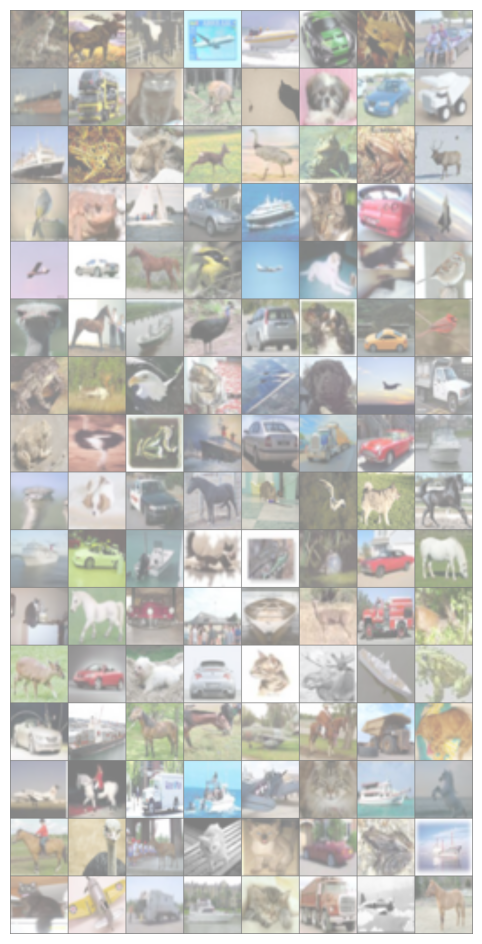

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: check the bug -> it is not an 8 by 8 figure, why?
# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1 Undo normalization: normalised = (original - 0.5) / 0.5] -> normalised * 2 +0.5 = original
    unnormalized_image_grid = image_tensor * 0.5 + 0.5

    # Step 2: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W = unnormalized_image_grid.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 3: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 4: Display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(train_loader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row


# Show the grid
show_image(image_grid)


## Get class labels

In [7]:
# TODO: Get the label directly cifar10_classes = cifar10.classes

cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(cifar10_classes [labels[0]])  


frog


# Convolutional Variational Autoencoder (Conv-VAE)
https://github.com/ageron/handson-mlp/blob/main/18_autoencoders_gans_and_diffusion_models.ipynb 

In [8]:
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Model

In [9]:
# ?nn.Linear

In [10]:
VAEOutput = namedtuple("VAEOutput", ["output", "codings_mean", "codings_logvar"])
# TODO: rename VAE model to CVAE
# TODO: try batchnorm, dropout
import torch
from torch import nn
from collections import namedtuple
from torchvision.models import mobilenet_v2

try:
    # Newer torchvision
    from torchvision.models import MobileNet_V2_Weights
    _MBV2 = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
except Exception:
    # Older torchvision fallback
    _MBV2 = mobilenet_v2(pretrained=True)

VAEOutput = namedtuple("VAEOutput", ["output", "codings_mean", "codings_logvar"])

class CVAE_MobileNetV2(nn.Module):
    """
    CVAE with MobileNetV2 encoder for 160x160 inputs.
    Inputs must be in [0,1] (Resize+ToTensor); decoder ends with Sigmoid.
    """
    def __init__(self, codings_dim=32):
        super().__init__()
        # --- Encoder backbone (features only): (B,3,160,160) -> (B,1280,5,5)
        self.encoder_backbone = _MBV2.features

        # Compress channels for a lighter decoder: 1280 -> 256
        self.enc_ch = 256
        self.spatial = 5  # 160/32 = 5
        self.compress = nn.Sequential(
            nn.Conv2d(1280, self.enc_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.enc_ch),
            nn.ReLU(inplace=True),
        )

        flat_dim = self.enc_ch * self.spatial * self.spatial  # 256*5*5 = 6400

        # --- Variational heads ---
        self.fc_mu     = nn.Linear(flat_dim, codings_dim)
        self.fc_logvar = nn.Linear(flat_dim, codings_dim)

        # --- Decoder: z -> (enc_ch,5,5) -> (B,3,160,160) ---
        self.fc_dec = nn.Linear(codings_dim, flat_dim)
        self.decoder = nn.Sequential(
            # 5 -> 10
            nn.ConvTranspose2d(self.enc_ch, 192, 4, 2, 1, bias=False),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),

            # 10 -> 20
            nn.ConvTranspose2d(192, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            # 20 -> 40
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            # 40 -> 80
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            # 80 -> 160
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16), nn.ReLU(inplace=True),

            # Final RGB
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),  # match [0,1] inputs
        )

    # --- VAE parts ---
    def encode(self, x):
        h = self.encoder_backbone(x)          # (B,1280,5,5)
        h = self.compress(h)                  # (B,256,5,5)
        h_flat = h.flatten(1)                 # (B,6400)
        mu = self.fc_mu(h_flat)               # (B,D)
        logvar = self.fc_logvar(h_flat)       # (B,D)
        return mu, logvar

    @staticmethod
    def sample_codings(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, self.enc_ch, self.spatial, self.spatial)  # (B,256,5,5)
        x_hat = self.decoder(h)                                               # (B,3,160,160) in [0,1]
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_codings(mu, logvar)
        out = self.decode(z)
        return VAEOutput(out, mu, logvar)


## Model training

In [25]:
def vae_loss(y_pred, x_target, kl_weight=1.0):
    output, mean, logvar = y_pred
    # MSE reconstruction
    recon = F.mse_loss(output, x_target)
    # recon = F.binary_cross_entropy_with_logits(output, x_target, reduction="mean") # logits + BCEWithLogitsLoss:
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.pow(2), dim=-1).mean()
    # Scale KL to per-pixel magnitude
    n_pixels = x_target[0].numel()
    return recon + kl_weight * (kl_div / n_pixels)

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            out = y_pred.output if isinstance(y_pred, tuple) else y_pred
            metric.update(out, X_batch)  # compare recon to input
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader, n_epochs=20):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for index, (X_batch, _) in enumerate(train_loader):
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, X_batch)   # use input as target
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            out = y_pred.output if isinstance(y_pred, tuple) else y_pred
            metric.update(out, X_batch)

        train_metric = metric.compute().item()
        val_metric = evaluate_tm(model, valid_loader, metric).item()

        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        history["valid_metrics"].append(val_metric)

        print(f"Epoch {epoch+1:02d}/{n_epochs} "
              f"loss={history['train_losses'][-1]:.4f}, "
              f"train RMSE={train_metric:.4f}, val RMSE={val_metric:.4f}")
    return history


torch.manual_seed(42)
cvae = CVAE_MobileNetV2(codings_dim=32).to(device)
# TODO: hyperparameter to tune -> learning rate
optimizer = torch.optim.NAdam(cvae.parameters(), lr=1e-5)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)

# TODO: hyperparameter to tune -> n_epochs
history = train(cvae, optimizer, vae_loss, rmse, train_loader, valid_loader, n_epochs=15)


Epoch 01/15 loss=0.0516, train RMSE=0.2264, val RMSE=0.1967


Epoch 02/15 loss=0.0316, train RMSE=0.1752, val RMSE=0.1554
Epoch 03/15 loss=0.0217, train RMSE=0.1435, val RMSE=0.1357
Epoch 04/15 loss=0.0181, train RMSE=0.1301, val RMSE=0.1267
Epoch 05/15 loss=0.0165, train RMSE=0.1238, val RMSE=0.1219
Epoch 06/15 loss=0.0158, train RMSE=0.1207, val RMSE=0.1197
Epoch 07/15 loss=0.0153, train RMSE=0.1189, val RMSE=0.1183
Epoch 08/15 loss=0.0150, train RMSE=0.1177, val RMSE=0.1174
Epoch 09/15 loss=0.0149, train RMSE=0.1170, val RMSE=0.1166
Epoch 10/15 loss=0.0147, train RMSE=0.1163, val RMSE=0.1161
Epoch 11/15 loss=0.0146, train RMSE=0.1158, val RMSE=0.1157
Epoch 12/15 loss=0.0145, train RMSE=0.1154, val RMSE=0.1154
Epoch 13/15 loss=0.0144, train RMSE=0.1150, val RMSE=0.1151
Epoch 14/15 loss=0.0143, train RMSE=0.1146, val RMSE=0.1146
Epoch 15/15 loss=0.0142, train RMSE=0.1141, val RMSE=0.1142


## Plot loss

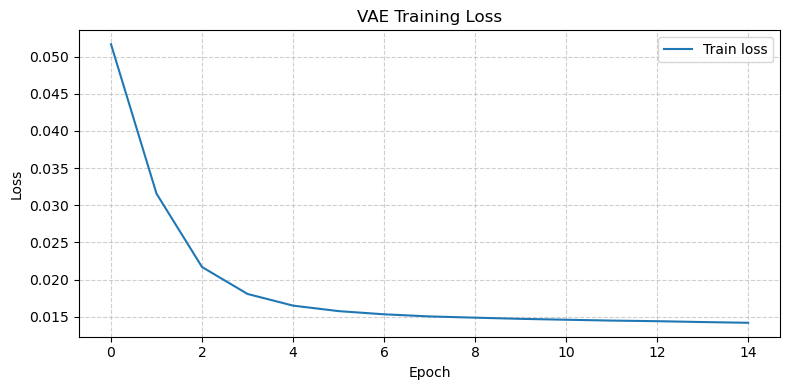

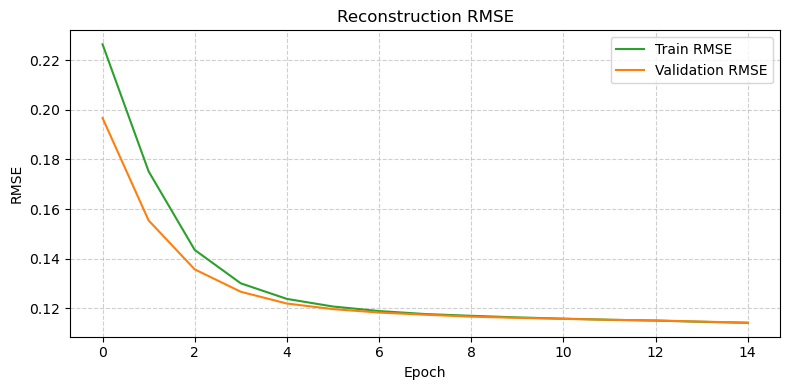

In [26]:
import matplotlib.pyplot as plt

# --- Plot training loss ---
plt.figure(figsize=(8, 4))
plt.plot(history["train_losses"], label="Train loss", color="tab:blue")
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot RMSE (train vs validation) ---
plt.figure(figsize=(8, 4))
plt.plot(history["train_metrics"], label="Train RMSE", color="tab:green")
plt.plot(history["valid_metrics"], label="Validation RMSE", color="tab:orange")
plt.title("Reconstruction RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Visualization

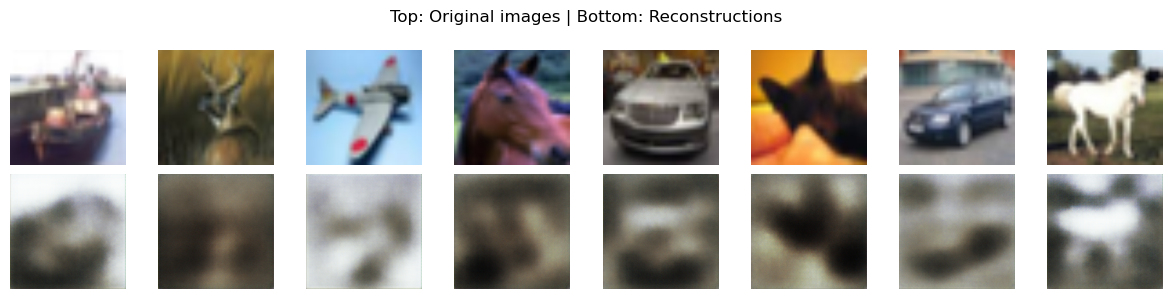

In [27]:
import matplotlib.pyplot as plt
import torch

def plot_image(img):
    """Convert a tensor to a displayable image and plot it."""
    img = img.detach().cpu()
    if img.ndim == 3:
        img = img.permute(1, 2, 0)  # (C,H,W) -> (H,W,C)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

def plot_reconstructions(model, data_loader, n_images=8):
    """
    Show original (top row) and reconstructed (bottom row) images from the VAE.
    """
    model.eval()

    # --- Get a batch of images ---
    X_batch, _ = next(iter(data_loader))
    X_batch = X_batch.to(device)
    X_batch = X_batch[:n_images]  # take first n_images only

    # --- Forward pass ---
    with torch.no_grad():
        out = model(X_batch)
        recon = out.output if hasattr(out, "output") else out

    # --- Plot originals and reconstructions ---
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 1.5, 3))

    for i in range(n_images):
        # Top row: original
        axes[0, i].imshow(X_batch[i].detach().cpu().permute(1, 2, 0))
        axes[0, i].axis("off")

        # Bottom row: reconstruction
        axes[1, i].imshow(recon[i].detach().cpu().permute(1, 2, 0))
        axes[1, i].axis("off")
    

    fig.suptitle("Top: Original images | Bottom: Reconstructions", fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Use it ---
plot_reconstructions(cvae, valid_loader, n_images=8)


# Exploration of the latent represenation (umap)

In [14]:
import torch
import numpy as np

def collect_mu(vae, loader, device):
    vae.eval()
    mus, ys = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = vae(x)
            # Handle both: namedtuple VAEOutput or plain tensor
            mu = out.codings_mean if hasattr(out, "codings_mean") else vae.encode(x)[0]
            mus.append(mu.detach().cpu().numpy())
            ys.append(y.numpy())
    X_mu = np.concatenate(mus, axis=0)   # shape: (N, codings_dim)
    y_all = np.concatenate(ys, axis=0)   # shape: (N,)
    return X_mu, y_all

# Example:
X_train_mu, y_train = collect_mu(cvae, train_loader, device)
X_valid_mu, y_valid = collect_mu(cvae, valid_loader, device)


In [15]:
# pip install umap-learn
import umap
from sklearn.preprocessing import StandardScaler

# TODO: try to improve by playing with the parameters

umap_2d = umap.UMAP(
    n_neighbors=15,      # local vs global structure (try 10–50)
    min_dist=0.1,        # how tight clusters look (0.0–0.5)
    n_components=2,      # 2D for plotting (set 3 for 3D)
    metric="euclidean",  # try "cosine" if features are directional
    random_state=42
)

# Z_train_2d = umap_2d.fit_transform(X_train_mu)  # (N_train, 2)
# Z_valid_2d = umap_2d.transform(X_valid_mu)      # (N_valid, 2)



scaler = StandardScaler().fit(X_train_mu)
X_train_mu_s = scaler.transform(X_train_mu)
X_valid_mu_s = scaler.transform(X_valid_mu)
Z_train_2d = umap_2d.fit_transform(X_train_mu_s)
Z_valid_2d = umap_2d.transform(X_valid_mu_s)


/storage/homefs/ae04q066/.conda/envs/py3.10/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


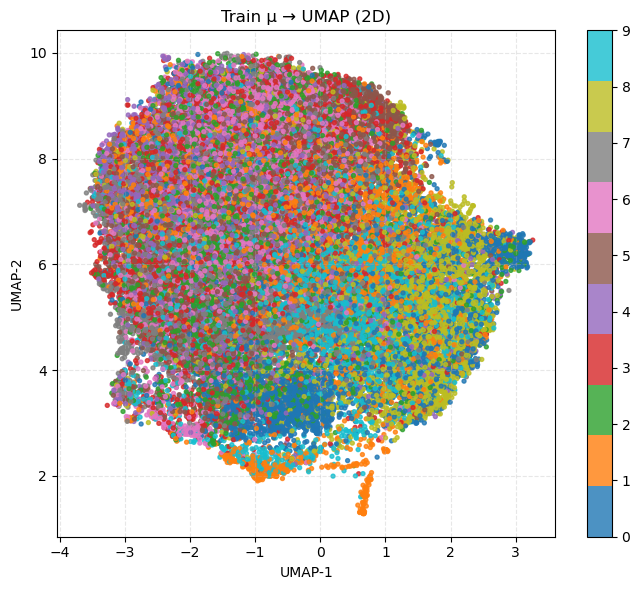

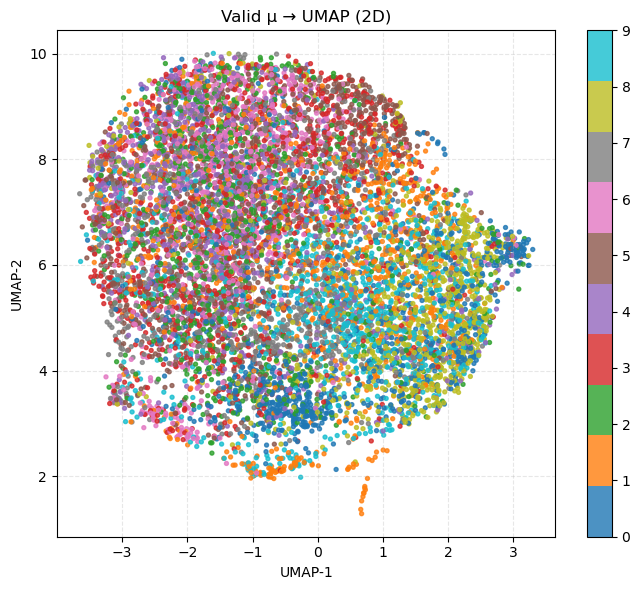

In [16]:
import matplotlib.pyplot as plt

def scatter_umap(Z, y, title="UMAP of VAE μ", num_classes=None):
    plt.figure(figsize=(7,6))
    sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=8, alpha=0.8, cmap="tab10")
    if num_classes is None:
        num_classes = len(np.unique(y))
    plt.colorbar(sc, ticks=range(num_classes))
    plt.title(title)
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

scatter_umap(Z_train_2d, y_train, title="Train μ → UMAP (2D)")
scatter_umap(Z_valid_2d, y_valid, title="Valid μ → UMAP (2D)")



Overall structure

* The map shows a continuous, dense cloud rather than distinct clusters.

* That’s expected — your autoencoder is trained unsupervised only to reconstruct images, not to separate classes.

* Therefore, latent codes mainly capture visual similarity (colors, textures, shapes) rather than semantic categories.

# Find outliers
test 

# Sample from the latent distribution

# overlay with data points
What does it mean?

# Feature extraction 
From latent space

In [17]:
import time

device = next(cvae.parameters()).device

# --- helper to collect μ and labels from a loader ---
def collect_mu(vae, loader, device, name="dataset"):
    vae.eval()
    mus, ys = [], []
    start_time = time.time()
    total_batches = len(loader)

    print(f"\n[INFO] Extracting features from {name} ({total_batches} batches)...")
    with torch.no_grad():
        for i, (x, y) in enumerate(loader, start=1):
            x = x.to(device, non_blocking=True)
            mu, _ = vae.encode(x)
            mus.append(mu.detach().cpu().numpy())
            ys.append(y.numpy())

            if i % 20 == 0 or i == total_batches:
                elapsed = time.time() - start_time
                print(f"  Batch {i:>4}/{total_batches} | Time elapsed: {elapsed:5.1f}s")

    X = np.concatenate(mus, axis=0)
    y = np.concatenate(ys, axis=0)
    print(f"[INFO] Done {name}: {X.shape[0]} samples, {X.shape[1]}-dim μs | Total time: {time.time()-start_time:.1f}s\n")
    return X, y


# 1) Extract μ for all splits
X_train, y_train = collect_mu(cvae, train_loader, device, "train set")
X_valid, y_valid = collect_mu(cvae, valid_loader, device, "validation set")
X_test, y_test = collect_mu(cvae, test_loader, device, "test set")

# 2) Standardize
print("[INFO] Standardizing features...")
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s = scaler.transform(X_test)
print("  Done scaling.\n")


[INFO] Extracting features from train set (313 batches)...
  Batch   20/313 | Time elapsed:   0.4s
  Batch   40/313 | Time elapsed:   0.7s
  Batch   60/313 | Time elapsed:   1.1s
  Batch   80/313 | Time elapsed:   1.4s
  Batch  100/313 | Time elapsed:   1.8s
  Batch  120/313 | Time elapsed:   2.1s
  Batch  140/313 | Time elapsed:   2.4s
  Batch  160/313 | Time elapsed:   2.7s
  Batch  180/313 | Time elapsed:   3.1s
  Batch  200/313 | Time elapsed:   3.4s
  Batch  220/313 | Time elapsed:   3.7s
  Batch  240/313 | Time elapsed:   4.0s
  Batch  260/313 | Time elapsed:   4.4s
  Batch  280/313 | Time elapsed:   4.7s
  Batch  300/313 | Time elapsed:   5.0s
  Batch  313/313 | Time elapsed:   5.2s
[INFO] Done train set: 40000 samples, 32-dim μs | Total time: 5.2s


[INFO] Extracting features from validation set (40 batches)...
  Batch   20/40 | Time elapsed:   0.9s
  Batch   40/40 | Time elapsed:   1.6s
[INFO] Done validation set: 10000 samples, 32-dim μs | Total time: 1.6s


[INFO] Extractin

# Train classifier/regressor 
Using the latent space representation of the samples

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import time
import numpy as np


## Helper functions

In [19]:
def evaluate_classifier(
    clf, # scikit-learn classifier or pipeline
    X: np.ndarray, 
    y: np.ndarray, 
    name: str="Model")->None:
    
    y_predicted = clf.predict(X)
    print(f"[{name}] Accuracy:", accuracy_score(y, y_predicted))
    print(classification_report(y, y_predicted, digits=4))
    return None

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_valid, y_valid, class_names=None,
                          title="Confusion Matrix", normalize=True, figsize=(7,6)):
    """
    Compute and plot the confusion matrix for a classifier.

    Parameters
    ----------
    model : trained classifier (e.g., SVM, MLP)
        Must implement `.predict()`.
    X_valid : array-like
        Validation features.
    y_valid : array-like
        True labels.
    class_names : list of str, optional
        Names of classes (e.g., CIFAR-10 class names). If None, uses label integers.
    title : str, optional
        Plot title.
    normalize : bool, optional
        Normalize each row to sum to 1.
    figsize : tuple, optional
        Figure size.
    """
    # --- Predict ---
    y_pred = model.predict(X_valid)

    # --- Compute confusion matrix ---
    cm = confusion_matrix(y_valid, y_pred)

    # --- Normalize if requested ---
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # --- Define labels for axes ---
    if class_names is None:
        labels = np.unique(y_valid)
    else:
        labels = class_names

    # --- Plot ---
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
        xticklabels=labels, yticklabels=labels
    )
    plt.title(title + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()



## Dummy classifier

In [20]:
# --- Dummy baseline classifier ---
# Strategy options:
# "most_frequent" → always predicts the most common class
# "stratified" → random predictions following class frequencies
# "uniform" → random uniform over classes
dummy = DummyClassifier(strategy="uniform", random_state=42)
dummy.fit(X_train_s, y_train)
y_dummy = dummy.predict(X_valid_s)
dummy_acc = dummy.score(X_valid_s, y_valid)

print(f"\nBaseline (DummyClassifier, strategy='most_frequent') Accuracy: {dummy_acc:.4f}\n")
print("Classification Report (Dummy Baseline):")
print(classification_report(y_valid, y_dummy, digits=4, zero_division=0))


Baseline (DummyClassifier, strategy='most_frequent') Accuracy: 0.1046

Classification Report (Dummy Baseline):
              precision    recall  f1-score   support

           0     0.1026    0.1070    0.1048      1009
           1     0.1056    0.1038    0.1047      1002
           2     0.0884    0.0911    0.0897       966
           3     0.1143    0.1096    0.1119      1013
           4     0.0915    0.0855    0.0884      1029
           5     0.1224    0.1273    0.1248       982
           6     0.1042    0.1077    0.1059       984
           7     0.0931    0.0914    0.0922       985
           8     0.1006    0.1017    0.1012       983
           9     0.1219    0.1203    0.1211      1047

    accuracy                         0.1046     10000
   macro avg     0.1044    0.1045    0.1045     10000
weighted avg     0.1046    0.1046    0.1045     10000



## Logistic regression

Validation Accuracy on UMAP(2D): 0.3480

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0     0.3959    0.4351    0.4145      1009
           1     0.3614    0.3942    0.3771      1002
           2     0.2273    0.1812    0.2016       966
           3     0.2727    0.1836    0.2195      1013
           4     0.3005    0.2255    0.2576      1029
           5     0.3213    0.3442    0.3324       982
           6     0.3393    0.4624    0.3914       984
           7     0.3649    0.3563    0.3606       985
           8     0.4164    0.4791    0.4456       983
           9     0.4026    0.4183    0.4103      1047

    accuracy                         0.3480     10000
   macro avg     0.3402    0.3480    0.3411     10000
weighted avg     0.3406    0.3480    0.3413     10000



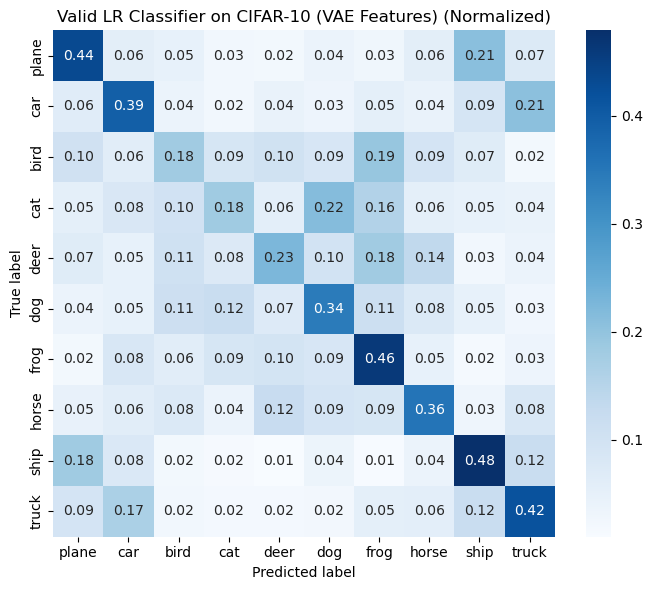

In [21]:
# --- Logistic Regression on UMAP features ---
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train_s, y_train)
y_pred = lr_clf.predict(X_valid_s)
acc = lr_clf.score(X_valid_s, y_valid)

print(f"Validation Accuracy on UMAP(2D): {acc:.4f}\n")
print("Classification Report (Logistic Regression):")
print(classification_report(y_valid, y_pred, digits=4))


plot_confusion_matrix(
    lr_clf,
    X_valid_s,
    y_valid,
    class_names=cifar10_classes,
    title="Valid LR Classifier on CIFAR-10 (VAE Features)"
)


Validation Accuracy on UMAP(2D): 0.3552

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0     0.4306    0.4620    0.4457      1000
           1     0.3620    0.3750    0.3684      1000
           2     0.2428    0.2120    0.2264      1000
           3     0.2521    0.1790    0.2094      1000
           4     0.3140    0.2270    0.2635      1000
           5     0.3304    0.3330    0.3317      1000
           6     0.3427    0.4640    0.3942      1000
           7     0.3724    0.3650    0.3687      1000
           8     0.4208    0.4970    0.4558      1000
           9     0.4124    0.4380    0.4248      1000

    accuracy                         0.3552     10000
   macro avg     0.3480    0.3552    0.3488     10000
weighted avg     0.3480    0.3552    0.3488     10000



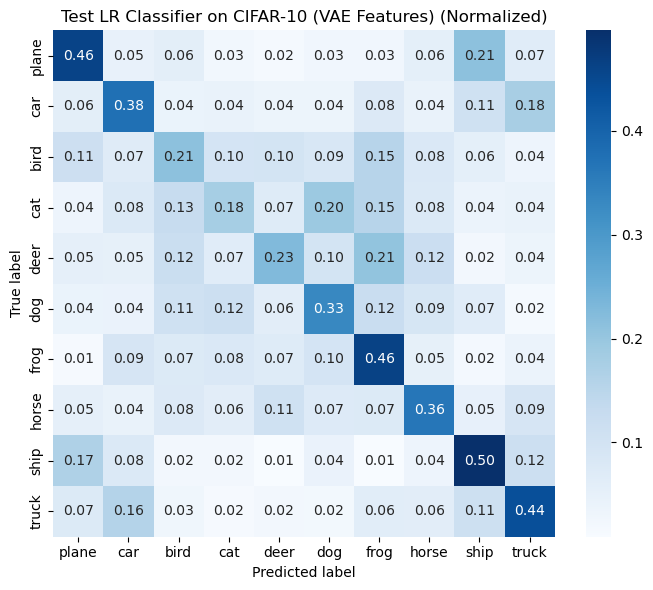

In [22]:
# --- Logistic Regression on UMAP features ---
# lr_clf = LogisticRegression(max_iter=1000, random_state=42)
# lr_clf.fit(X_train_s, y_train)
y_pred = lr_clf.predict(X_test_s)
acc = lr_clf.score(X_test_s, y_test)

print(f"Test Accuracy on UMAP(2D): {acc:.4f}\n")
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred, digits=4))


plot_confusion_matrix(
    lr_clf,
    X_test_s,
    y_test,
    class_names=cifar10_classes,
    title="Test LR Classifier on CIFAR-10 (VAE Features)"
)


## Support vector machine

[SVM] Accuracy: 0.3424
              precision    recall  f1-score   support

           0     0.3724    0.4500    0.4075      1009
           1     0.3464    0.3802    0.3625      1002
           2     0.2410    0.1108    0.1518       966
           3     0.3228    0.1313    0.1867      1013
           4     0.3157    0.1448    0.1985      1029
           5     0.3122    0.3666    0.3372       982
           6     0.3188    0.4919    0.3869       984
           7     0.3553    0.3452    0.3502       985
           8     0.3721    0.5463    0.4427       983
           9     0.3736    0.4575    0.4113      1047

    accuracy                         0.3424     10000
   macro avg     0.3330    0.3424    0.3235     10000
weighted avg     0.3335    0.3424    0.3237     10000



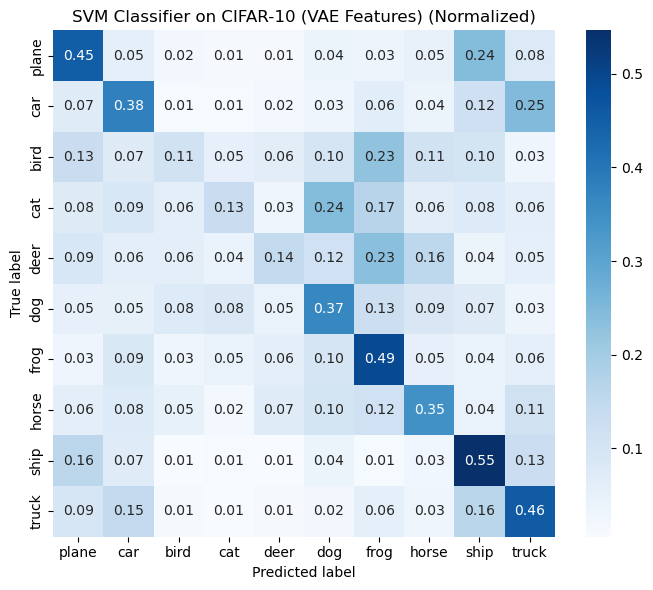

In [23]:
svm_clf: Pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(dual=False, C=1.0, max_iter=5000, random_state=42)
)

svm_clf.fit(X_train_s, y_train)

# Evaluate on valid features
evaluate_classifier(clf=svm_clf, 
                    X=X_valid_s, 
                    y=y_valid, 
                    name="SVM")

plot_confusion_matrix(
    svm_clf,
    X_valid_s,
    y_valid,
    class_names=cifar10_classes,
    title="SVM Classifier on CIFAR-10 (VAE Features)"
)

In [24]:
# import time
# import numpy as np
# import torch
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# device = next(vae.parameters()).device

# # --- helper to collect μ and labels from a loader ---
# def collect_mu(vae, loader, device, name="dataset"):
#     vae.eval()
#     mus, ys = [], []
#     start_time = time.time()
#     total_batches = len(loader)

#     print(f"\n[INFO] Extracting features from {name} ({total_batches} batches)...")
#     with torch.no_grad():
#         for i, (x, y) in enumerate(loader, start=1):
#             x = x.to(device, non_blocking=True)
#             mu, _ = vae.encode(x)
#             mus.append(mu.detach().cpu().numpy())
#             ys.append(y.numpy())

#             if i % 20 == 0 or i == total_batches:
#                 elapsed = time.time() - start_time
#                 print(f"  Batch {i:>4}/{total_batches} | Time elapsed: {elapsed:5.1f}s")

#     X = np.concatenate(mus, axis=0)
#     y = np.concatenate(ys, axis=0)
#     print(f"[INFO] Done {name}: {X.shape[0]} samples, {X.shape[1]}-dim μs | Total time: {time.time()-start_time:.1f}s\n")
#     return X, y


# # 1) Extract μ for all splits
# X_train, y_train = collect_mu(vae, train_loader, device, "train set")
# X_valid, y_valid = collect_mu(vae, valid_loader, device, "validation set")

# # 2) Standardize
# print("[INFO] Standardizing features...")
# scaler = StandardScaler().fit(X_train)
# X_train_s = scaler.transform(X_train)
# X_valid_s = scaler.transform(X_valid)
# print("  Done scaling.\n")

# # 3) Train the MLP
# print("[INFO] Training MLP classifier on latent μ features...")
# start = time.time()
# clf = MLPClassifier(hidden_layer_sizes=(256,), max_iter=100, alpha=1e-4, random_state=42)
# clf.fit(X_train_s, y_train)
# print(f"  MLP training done in {time.time()-start:.1f}s\n")

# # 4) Evaluate
# print("[INFO] Evaluating on validation set...")
# y_pred_val = clf.predict(X_valid_s)
# val_acc = accuracy_score(y_valid, y_pred_val)
# print(f"\nValidation accuracy (μ → MLP): {val_acc:.4f}\n")

# print("Classification Report (Validation):")
# print(classification_report(y_valid, y_pred_val, digits=4, zero_division=0))

# cm = confusion_matrix(y_valid, y_pred_val)
# print("Confusion Matrix (Validation):")
# print(cm)
